--------------------------------------------------------------------------------
Travel time calculation using ModPathWell class, combined with 'omp removal'
--------------------------------------------------------------------------------

Example to calculate the travel time distribution per geological layer for a 
.. phreatic scheme, and to calculate the removal of organic micropollutants (OMP). 
.. For an extensive description of the steps, see the basic example [AnalyticalWell & OMP removal](https://github.com/KWR-Water/sutra2/blob/main/research/Tutorial_AW_omp_removal.ipynb).

________________________________________

Import packages
-----------------

First we import the necessary python packages

In [1]:
import pandas as pd
from pathlib import Path
from set_cwd_to_project_root import project_root

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pandas import read_csv
from pandas import read_excel
import math
from scipy.special import kn as besselk
import sutra2.Analytical_Well as AW
import sutra2.ModPath_Well as mpw
import sutra2.Transport_Removal as TR

import warnings 
warnings.filterwarnings(action= 'ignore')

# get directory of this file
path = Path(project_root)
print(path)

%load_ext autoreload
%autoreload 2

3.3.5
d:\Sutra2_tool\sutra2\research


Step 1: Define the HydroChemicalSchematisation
-----------------------------------------------
The first step is to define the hydrogeochemistry of the system using the HydroChemicalSchematisation class.

In [2]:
# Lets start with a simple example defining a HydroChemicalSchematisation object for a phreatic aquifer:
phreatic_schematisation = AW.HydroChemicalSchematisation(schematisation_type='phreatic',
                                                    computation_method = 'modpath',
                                                    well_discharge=-7500, #m3/day
                                                    recharge_rate=0.0008, #m/day
                                                    thickness_vadose_zone_at_boundary=5, #m
                                                    thickness_shallow_aquifer=10,  #m
                                                    thickness_target_aquifer=40, #m
                                                    hor_permeability_target_aquifer=35, #m/day
                                                    redox_vadose_zone='anoxic',
                                                    redox_shallow_aquifer='anoxic',
                                                    redox_target_aquifer='deeply_anoxic',
                                                    pH_target_aquifer=7.,
                                                    temp_water=11.,
                                                    diffuse_input_concentration = 100, #ug/L
                                                    )

Then, we create a ModpathWell object for the HydroChemicalSchematisation object that we just made.
The ModpathWell object requires a dictionary of the subsurface schematisation and a set of boundary conditions the numerical model has to abide by in calculating flow velocity and direction of flow.

In [3]:
phreatic_schematisation.make_dictionary()

Step 2: Run the ModpathWell class
-----------------------------------
Next we create an ModpathWell object for the HydroChemicalSchematisation object we just made.
The data files will be stored in location workspace using a given modelname.

In [4]:
modpath_phrea = mpw.ModPathWell(phreatic_schematisation,
                            workspace = os.path.join(path,"omp_removal"),
                            modelname = "phreatic")

Now we run the Modpath model, which numerically calculates the flow in the subsurface using the 
'schematisation' dictionary stored in the HydroChemicalSchematisation object. By default the model will calculate both the hydraulic head distribution (using modflow: 'run_mfmodel' = True) and the particle pathlines [X,Y,Z,T-data] (using modpath: 'run_mpmodel' = True) with which OMP removal or microbial organism ('mbo') removal is later calculated.


In [5]:
modpath_phrea.run_model(run_mfmodel = True,
                    run_mpmodel = True)

Run phreatic model
Run model: d:\Sutra2_tool\sutra2\research\omp_removal phreatic

FloPy is using the following executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.9.01 5/01/2012                        

 Using NAME file: phreatic.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/08/22 16:02:12

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/08/22 16:02:12
 Elapsed run time:  0.050 Seconds

  Normal termination of simulation
Model run d:\Sutra2_tool\sutra2\research\omp_removal phreatic completed without errors: True
Run modpath: d:\Sutra2_tool\sutra2\research\omp_removal phreatic

FloPy is using the following executable to run the model: .\mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 

Step 3: Collect removal parameters for the OMP
-----------------------------------------------

You can retrieve the default removal parameters used to calculate the removal of organic micropollutants [OMP] in the Transport class. The data are stored in a dictionary

In [6]:
test_substance = TR.Substance(substance_name='benzene')
test_substance.substance_dict

{'substance_name': 'benzene',
 'log_Koc': 1.92,
 'molar_mass': 78.1,
 'pKa': 99,
 'omp_half_life': {'suboxic': 10.5, 'anoxic': 420, 'deeply_anoxic': 1e+99}}

> Note: for microbial organisms call the MicrobialOrganism class.
> See example for AnalyticalWell plus mbo removal.
> 
> test_organism = TR.MicrobialOrganism(organism_name='MS2')
> test_organism.organism_dict

____________________________________

Step 4: Run the Transport class
--------------------------------
To calculate the removal and the steady-state concentration in each zone, create a concentration
object by running the Transport class with the phreatic_well object and specifying
the OMP (or pathogen) of interest.

In this example we use benzene. First we create the object and view the substance properties:


In [7]:
phreatic_transport = TR.Transport(well = modpath_phrea, pollutant = test_substance)
phreatic_transport.removal_parameters

{'substance_name': 'benzene',
 'log_Koc': 1.92,
 'molar_mass': 78.1,
 'pKa': 99,
 'omp_half_life': {'suboxic': 10.5, 'anoxic': 420, 'deeply_anoxic': 1e+99}}

Then we can compute the removal by running the 'compute_omp_removal' function:

In [8]:
phreatic_transport.compute_omp_removal()

Once the removal has been calculated, you can view the steady-state concentration
and breakthrough time per zone for the OMP in the df_particle:

In [9]:
phreatic_transport.df_particle.loc[:,['zone', 'steady_state_concentration', 'travel_time']]

,zone,steady_state_concentration,travel_time
flowline_id,,,
0,vadose_zone,100,0.000000
0,shallow_aquifer,2.748794,3714.000000
0,target_aquifer,2.748794,0.292480
0,gravelpack1,2.748761,0.009766
0,well1,2.748758,0.000977
...,...,...,...
49,target_aquifer,0.231343,0.164062
49,target_aquifer,0.231343,0.125000
49,target_aquifer,0.231343,0.078125


View the steady-state concentration of the flowline or the steady-state
contribution of the flowline to the concentration in the well

In [10]:
phreatic_transport.df_flowline.loc[:,['breakthrough_concentration', 'total_breakthrough_travel_time']].head(5)

,breakthrough_concentration,total_breakthrough_travel_time
flowline_id,,
0,2.748758,22198
1,3.397070,30182
2,3.597075,34227
3,3.879517,37897
4,4.182568,41353


Plot the breakthrough curve at the well over time:

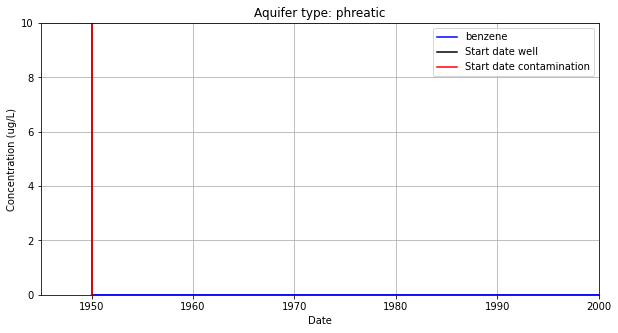

In [11]:
benzene_plot = phreatic_transport.plot_concentration(ylim=[0,10 ])

You can also compute the removal for a different OMP of interest:

* OMP-X: a ficticous OMP with no degradation or sorption
* AMPA
* benzo(a)pyrene

To do so you can use the original schematisation, but specify a different OMP when you create
the Transport object.

For an extensive description of these steps, see the basic example [AnalyticalWell & OMP removal](https://github.com/KWR-Water/sutra2/blob/main/research/Tutorial_AW_omp_removal.ipynb).

> Note: rerun the modpath model to clean the df_particle and df_flowline before calculating the advective removal
> 
> modpath_phrea.run_model(run_mfmodel = True,
>                    run_mpmodel = True) 